In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook
import seaborn as sns
import operator
import random
import re
from itertools import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix,accuracy_score
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
from sklearn.model_selection import ParameterGrid

In [4]:
dat = pd.read_csv("creditcard.csv")

In [5]:
dat = dat[:100000]

## 1. Data Visualizations

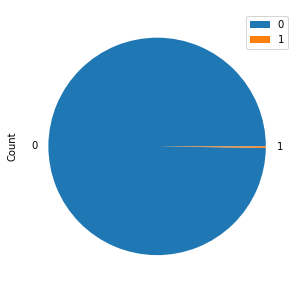

In [6]:
%matplotlib inline 
data = dat.copy()
data[["Time", "Class"]].groupby("Class").count().rename(columns = {"Time": "Count"}).plot.pie(y="Count", figsize=(5, 5))

## 2. Data Cleaning

In [7]:
def data_clean(data):
    Or = data.shape[0]
    
    #drop missing values
    data = data[data.notnull()]
    print("Totally clean %s missing values" % (Or - data.shape[0]))
    
    #drop duplicate records
    data = data.drop_duplicates()
    print("Totally clean %s dupilcate records" % (Or - data.shape[0]))
    
    print("Cleaning Ends!")
    return data#,fra_ct,non_fra_ct,fra_idx,non_fra_idx

In [8]:
def frad_info(data):
    fra_ct = sum(data['Class'] == 1)
    non_fra_ct = data.shape[0] - fra_ct
    fra_idx = data[data['Class'] == 1].index
    non_fra_idx = data[data['Class'] == 0].index
    
    return fra_ct,non_fra_ct,fra_idx,non_fra_idx

In [9]:
df_org = data_clean(dat)

Totally clean 0 missing values
Totally clean 381 dupilcate records
Cleaning Ends!


In [10]:
fra_ct,non_fra_ct,fra_idx,non_fra_idx = frad_info(df_org)

In [11]:
print("The number of fraud is %s" % (fra_ct))
print("The number of non-fraud is %s" % (non_fra_ct))

The number of fraud is 223
The number of non-fraud is 99396


## 3. Preparations for Modeling

### Baseline Functions

In [12]:
# split the data into training, validation, and testing set
def tra_test_val_split(data, label):
    '''
    function that split the data set into 'training', 'validation', and 'testing' data
    
    inputs:
        - data: the entire data set you want to split
        - label: the name of the target variable
    '''
    y = data[label]
    x = data.drop(label,axis = 1)
    x_train,x_test,y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)
    x_train,x_val,y_train, y_val = train_test_split(x_train,y_train,test_size = 0.2, random_state = 42)    
    return x_train,y_train,x_val,y_val,x_test, y_test

In [13]:
def FitModel(clf, x_tra,y_tra,x_val,y_val): # return the f score on validation set
    clf.fit(x_tra,y_tra)

    train_pred = clf.predict(x_tra)
    val_pred = clf.predict(x_val)

    AUC_train = roc_auc_score(y_tra, train_pred)
    AUC_val = roc_auc_score(y_val, val_pred)

    f = f1_score(y_val, val_pred)
    #print(AUC_train,AUC_val,f)
    return f

In [14]:
# logistics regression with non-resampled dataset 
def LR_result(data,label):
    x_train,y_train,x_val,y_val,x_test, y_test = tra_test_val_split(data, label)
    LR_res = {}
    paras_lr = [10 ** i for i in range(-2,2)]
    for c in paras_lr:
        LR = LogisticRegression(random_state = 20, C = c)
        LR_res[c] = FitModel(LR, x_train, y_train, x_val, y_val)
    position = list(LR_res.values()).index(min(list(LR_res.values())))
    best_c = list(LR_res.keys())[position]
    
    # fit training + validation data
    LR_best = LogisticRegression(random_state = 20, C = best_c)
    X = pd.concat([x_train, x_val], axis = 0)#, sort = False)
    Y = pd.concat([y_train, y_val], axis = 0)#, sort = False)
    test_pred = LR_best.fit(X,Y).predict(x_test)
    print("Accurancy on testing:"+str(accuracy_score(y_test, test_pred)))
    print("Recall on testing:"+str(recall_score(y_test, test_pred)))
    
    # return f1_score of testing data
    return best_c, f1_score(y_test, test_pred)

In [15]:
LR_result(df_org,label = "Class")

Accurancy on testing:0.9985946597068862
Recall on testing:0.5319148936170213


(1, 0.641025641025641)

### Re-sampling Functions

#### Under_sampling

In [16]:
# under-sample 
def under_sample(resample_rate,x,y,label):
    '''
    function that resamples data and returns the data after resampling
    inputs:
        - resample_rate: rate that will be multiplied to the number of data in the majority class
        - label: the name of the target variable
    '''
    data = pd.concat([x, y], axis = 1)
    fra_ct,non_fra_ct,fra_idx,non_fra_idx = frad_info(data)
    rnd_idx = np.random.choice(non_fra_idx,int(resample_rate * non_fra_ct), replace=False)
    under_sample_indices = np.concatenate([fra_idx,rnd_idx])
    df_under_sample = data.loc[under_sample_indices]
    y_under = df_under_sample[label]
    x_under = df_under_sample.drop(label,axis = 1)
    return x_under, y_under

#### Over_sampling

In [17]:
# over-sample
def over_sample(resample_rate,x,y,label):
    data = pd.concat([x, y], axis = 1)
    fra_ct,non_fra_ct,fra_idx,non_fra_idx = frad_info(data)
    rnd_idx = np.random.choice(fra_idx,int(resample_rate * fra_ct), replace=True)
    over_sample_indices = np.concatenate([non_fra_idx,rnd_idx])
    df_over_sample = data.loc[over_sample_indices]
    y_over = df_over_sample[label]
    x_over = df_over_sample.drop(label,axis = 1)
    return x_over, y_over

#### Hybrid_sampling

In [18]:
# hybrid sample 
def hybrid_sample(resample_rate, x, y, label):
    '''
    function that returns the data after resampling
    input:
        - resample_rate: the ratio of minority data/ majority data after resampling
        - label: target variable
    '''
    smt = SMOTETomek(ratio = resample_rate)
    x_res, y_res = smt.fit_sample(x, y)
    x_hybrid = pd.DataFrame(x_res, columns = x.columns)
    y_hybrid = pd.DataFrame(y_res, columns = [label])
    return x_hybrid, y_hybrid

#### split the data into training,and testing set

In [19]:
# split the data into training,and testing set
def tra_test_split(data, label):
    '''
    function that split the data set into 'training' and 'testing' data
    
    inputs:
        - data: the entire data set you want to split
        - label: the name of the target variable
    '''
    y = data[label]
    x = data.drop(label,axis = 1)
    x_train,x_test,y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)   
    return x_train,y_train,x_test, y_test

In [20]:
def partition (list_in, n):
    '''
    function used do partition for data (used for cross-validation)
    '''
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

In [21]:
def train_models(x_train,y_train, models,split):
    '''
    function used to fit models
    '''
    best_estimator = None # initialize best_param as an empty dictionary
    best_score = 0
    best_model = None
    best_models={}
    
    ## 3) Train models in the models dictionary
    for classifier in models:
        classifier_name = " ".join(re.findall('[A-Z][a-z]*', str(classifier).split(".")[-1].split("'")[0]))
        


#         print("Model Report for " + str(classifier) + " :")
        
        for params in ParameterGrid(models[classifier]):
            clf= classifier(**params)
#             print(params)
            data_dic = {}
            data_split = partition(list(x_train.index),split)

            
            score_cv = []
            for i in range(split):
                cv_x_train = x_train.loc[list(set(x_train.index) - set(data_split[i]))]
                cv_y_train = y_train.loc[list(set(x_train.index) - set(data_split[i]))]
                cv_x_val = x_train.loc[data_split[i]]
                cv_y_val = y_train.loc[data_split[i]]
                clf.fit(cv_x_train,cv_y_train)
                val_pred = clf.predict(cv_x_val)
                f = f1_score(cv_y_val, val_pred)
                score_cv.append(f)
            final_score = np.mean(score_cv)
#             print(final_score)
            
            

            # choose the best parameter set for that classifier in best_models dictionary
            if final_score > best_score:
                best_score = final_score
                best_estimator = params
                best_model = classifier_name
            
    best_models[best_model] = [best_estimator, best_score]

    
    # return the best_models dictionary
    return best_models

In [22]:
def try_models(func_name, models,split,rate_ls):
    '''
    a function that resample data set and train all potential models
    inputs:
        - sampling_method: a string, a sampling method chosen, e.g. "under_sampling"
        - models: a dictionary with model classifiers as keys, potential parameters as values
        - split: int, similar to KFolds for validation (for the purpose of cross-validation)
    '''
    
    ## 1) split the data for training, validation and testing
    x_train,y_train,x_test, y_test = tra_test_split(df_org,"Class")
    
    ## 2) resample data based on the sampling method chosen
    
    # initialize an empty dictionary that stores the sampling rate chosen and the corresponding best estimators generated
    all_best_models = {}
    
    for rate in rate_ls:
        x_train_new,y_train_new = func_name(rate, x_train, y_train, "Class")
        best_model = train_models(x_train_new,y_train_new,models,split)
        all_best_models[rate] = best_model
    
    return all_best_models, x_train,y_train,x_test, y_test

## 4. Modeling

##### Resampling rates

In [29]:
# list of sampling rates we want to try:
under_sample_rate = [0.002, 0.0015]
over_sample_rate = [2,5,10]
hybrid_sample_rate = [0.5, 0.8, 1]

##### All models we want to try out

In [24]:
# models: a dictionary that stores the possible parameter sets we want to try out for each classifier

models = {LogisticRegression:{'C':[10**i for i in range(-5,5)],
                              'penalty':['l1','l2'],
                             'verbose': [1]},
          
          RandomForestClassifier: {'criterion':['entropy'],
                                   'bootstrap': [True],
                                   'n_estimators': [300, 500, 1000],
                                    'max_features': ['auto', 'sqrt'],
                                    'max_depth': [10, 20, 30],
                                    'min_samples_split': [2, 10, 100],
                                    'min_samples_leaf': [1, 5, 10],
                                  'verbose': [1]},
          
          XGBClassifier:{'eta': [0.01, 0.1],
                         'max_depth': range(3,10,2),
                         'min_child_weight': range(1,6,2),
                         'gamma': [0, 1],
                         'subsample': [i/10.0 for i in range(6,10)],
                         'colsample_bytree': [i/10.0 for i in range(6,10)],
                         'n_estimators': [300, 500, 1000],
                        'verbose': [1]}
         }


In [27]:
models = {RandomForestClassifier: {'criterion':['entropy'],
                                   'bootstrap': [False],
                                   'n_estimators': [300]}}

##### Model names

In [26]:
# model_names: store all the names of the models

model_names = []
for model in models:
    model_names.append(" ".join(re.findall('[A-Z][a-z]*', str(model).split(".")[-1].split("'")[0])))

model_names

['Logistic Regression', 'Random Forest Classifier', 'X G B Classifier']

### Training

Under-sampling

In [ ]:
under_all_best_models, x_train,y_train,x_test, y_test = try_models(under_sample, models,split = 3,rate_ls = under_sample_rate)
k = under_all_best_models

# print out the modeling results
for rate in k.keys():
    print("sampling rate =    " + str(rate) + ": \n")
    for name in k[rate].keys():
        print("best estimator:    " + str(name) + "\n")
    for combo in k[rate].values():
        print("best parameters:   " + str(combo[0]))
        print("f_1 score:         " + str(combo[1]))
    print("-----------------------------------------------------------------------------------")

Over-sampling

In [30]:
over_all_best_models, x_train,y_train,x_test, y_test = try_models(over_sample, models,split = 3,rate_ls = over_sample_rate)
k = over_all_best_models

# print out the modeling results
for rate in k.keys():
    print("sampling rate =    " + str(rate) + ": \n")
    for name in k[rate].keys():
        print("best estimator:    " + str(name) + "\n")
    for combo in k[rate].values():
        print("best parameters:   " + str(combo[0]))
        print("f_1 score:         " + str(combo[1]))
    print("-----------------------------------------------------------------------------------")

sampling rate =    2: 

best estimator:    Random Forest Classifier

best parameters:   {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 300}
f_1 score:         0.8812546051910318
-----------------------------------------------------------------------------------
sampling rate =    5: 

best estimator:    Random Forest Classifier

best parameters:   {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 300}
f_1 score:         0.7985093840504525
-----------------------------------------------------------------------------------
sampling rate =    10: 

best estimator:    Random Forest Classifier

best parameters:   {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 300}
f_1 score:         0.34071944829276196
-----------------------------------------------------------------------------------


Hybrid-sampling

In [ ]:
hybrid_all_best_models, x_train,y_train,x_test, y_test = try_models(hybrid_sample, models,split = 3,rate_ls = hybrid_sample_rate)
k = hybrid_all_best_models

# print out the modeling results
for rate in k.keys():
    print("sampling rate =    " + str(rate) + ": \n")
    for name in k[rate].keys():
        print("best estimator:    " + str(name) + "\n")
    for combo in k[rate].values():
        print("best parameters:   " + str(combo[0]))
        print("f_1 score:         " + str(combo[1]))
    print("-----------------------------------------------------------------------------------")

### Model Comparison

In [48]:
# the chosen best estimator: a classifier object
best_classifier =  RandomForestClassifier(**{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 300})

#### Feature Importance

In [ ]:
## combine all training and validation data to retrain:
X_train = pd.concat([x_train, x_val])
Y_train = pd.concat([y_train, y_val])

best_classifier.fit(X_train, Y_train)

In [59]:
# predict training data
y_pred = best_classifier.predict(x_test)
test_f = f1_score(y_test, y_pred)
print("f1 score for testing data is: " + str(round(test_f,3)))
precision = precision_score(y_test, y_pred)
print("precision score for testing data is " + str(round(precision,3)))
recall = recall_score(y_test, y_pred)
print("recall score for testing data is " + str(round(recall,3)))
roc_auc = roc_auc_score(y_test, y_pred)
print("auc score for testing data is " + str(round(roc_auc,3)))

f1 score for testing data is: 0.828
precision score for testing data is 0.97
recall score for testing data is 0.722
auc score for testing data is 0.861


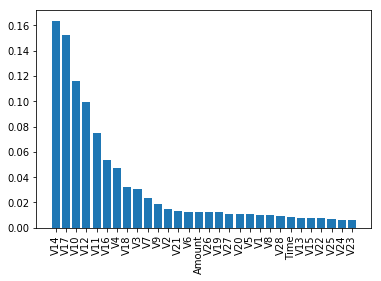

In [62]:
# plot feature importance bar plot
%matplotlib inline
features_list = X_train.columns
importances = best_classifier.feature_importances_

temp = sorted(dict(zip(importances, X_train.columns)).items())[::-1]
sorted_features_names = []
sorted_features_vals = []
for val, name in temp:
    sorted_features_names.append(name)
    sorted_features_vals.append(val)
    
plt.bar(range(30), sorted_features_vals, align = 'center')
plt.xticks(range(30), sorted_features_names, rotation = 90)
plt.show()

#### Confusion Matrix

In [70]:
def plot_confusion_matrix(cm, target_names, model_name, cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools
    # the text to display at the top of the matrix
    title = 'Confusion matrix of ' + model_name

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

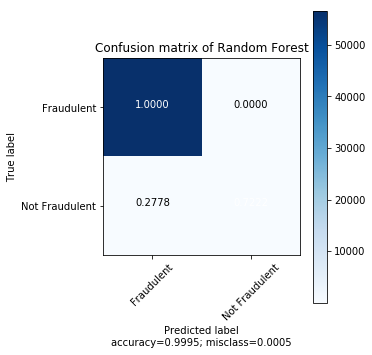

In [71]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
target_names = ['Fraudulent', 'Not Fraudulent']
plot_confusion_matrix(cm, target_names, 'Random Forest', cmap=None, normalize=True)

In [77]:
np.sum(y_test == 1), np.sum(y_test == 0)

(90, 56656)